This code seeks to visualise the randomness in the generators provided.

## Required installs/imports


In [ ]:
# https://pypi.org/project/pure-prng/
# Installs the library used to utilise modern PRNGs
!pip install pure-prng

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 47.6 MB/s eta 0:00:00


In [ ]:
# Used to round floats
import numpy as np
# Aids seeding by allowing the current time to be used as a seed
import time
# Provides python implementations of common PRNGs
from pure_prng_package import pure_prng

# Necessary imports to allow model development
import numpy as np
import tensorflow as tf
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
#
from IPython.display import display
from PIL import Image

## Classes to provide data generation/evaluation methods

In [ ]:
# Class used to access my implmentations of PRNGs
class PRNGManagement():
  # Initialises object and sets the default seed
  def __init__(self, seed=0):
      self.seed = seed
      self.random_number:int = seed
      self.currentGenerator = self.zero_only_PRNG()

  # Method to seed the PRNG (seeds all PRNGs in class)
  def seed_PRNG(self, seed:int):
    self.seed:int = seed
    self.random_number:int = seed

  def set_generator(self, generatorMethod):
    self.currentGenerator = generatorMethod

  def bit_success(self, model, inputData, trueOutputs, sequence_length):
    """ 
    Method to evaluate the provided model and store the amount of
    successful predictions for each bit of the output
    :param model: keras model - Model used to generate predicitions
    :param trueOutputs: list[list[int]]- List containing the expected y outputs
    :param sequence_length: int - Length of generated binary string being predicited
    :return list[int] - Amount of successful predictions for each bit
    """
    # Set initial amount of successful predictions for each bit to zero
    successfulPredicts = [0]*sequence_length
    # Feeds the input data to the model and stores the predictions made
    predicted = (model.predict(inputData).round())
    # Iterate over all outputed data
    for testIndex in range(0, len(inputData)):
      # Iterate over each bit in output
      for i in range(sequence_length):
        # If the predicted bit matches the true bit value then increment the successful predicts for the current bit
        if predicted[testIndex][i] == trueOutputs[testIndex][i]: successfulPredicts[i] += 1
        # Prediction may be greater than 1 if the prediction is made with high certainity
        elif predicted[testIndex][i] > 1 and trueOutputs[testIndex][i] == 1: self.successfulPredicts[i] += 1

    return successfulPredicts
   

  def zero_only_PRNG(self, length=100):
    """ 
    Returns a binary string containing only 0 of specified length.
    Used to test for major flaws in models
    :param length: int - Length of generated binary string
    :return string - generated binary string
    """
    return "0" * length        


  def alternating_bits_PRNG(self, length=100):
    """ 
    Returns output of a basic PRNG implementation that alernates each bit (010101)
    :param length: int - Length of generated binary string
    :return string - generated binary string
    """
    # Use seed to determine the starting bit of the generated binary string
    self.seed = self.seed%2
    # Utilises efficent method to repeat a string pattern
    if (self.seed == 1):
        output = "10" * int(length/2)
    else:
        output = "01" * int(length/2)

    # Length of generated binary string is odd
    if (length%2 == 1):
      # Add final bit to string
      output += str(self.seed)
      # Set the new seed value
      if (self.seed == 0): self.seed = 1
      else: self.seed = 0
    
    return output


  def alternating_num_PRNG(self):
    """ 
    Returns output of a basic PRNG implementation that alernates between two binary strings
    :return string - generated binary string
    """
    # Use seed to determine the binary string to be returned
    self.seed = (self.seed+1)%2
    if (self.seed == 0):
      # Convert integer to a binary string 
      randomBinary = str(bin(1643712566))[2:]
      # Returns binary string after ensuring a minimum length of 32
      return (32-len(randomBinary))*"0" + randomBinary
    else:
      # Convert integer to a binary string 
      randomBinary = str(bin(2372817037))[2:]
      # Returns binary string after ensuring a minimum length of 32
      return (32-len(randomBinary))*"0" + randomBinary


  def basic_equation_based(self, mult:int, add:int, mod:int, leng:int) -> str:
    """ 
    Returns output of an equation based LCG PRNG implementation
    Expected to be predicted near perfectly
    :return string - generated binary string
    """
    # Generates random number using previous output as seed
    self.random_number = (mult * self.random_number + add) % mod
    # Converts generated number to a binary string
    bits_string = bin(self.random_number)[2:]
    # Returns binary string after using padding to ensure a length of 32
    return bits_string.zfill(leng)


  ## Different implmentations of equation based generators
  def basic_equation_based1(self) -> str:
    return self.basic_equation_based(20, 52, 2**32, 32)

  def basic_equation_based2(self) -> str:
    return self.basic_equation_based(36791, 83247, 2**32, 32)

  # Expects odd starting seed
  # Imeplementation of the PRNG 'RANDU' - Outdated PRNG
  def RANDU(self) -> str:
    return self.basic_equation_based(65539, 0, 2**31, 31)

  # Implementation of the Park Miller MINSTD PRNG
  def Park_Miller(self) -> str:
    return self.basic_equation_based(16807, 0, 2**31-1, 32)

  # Get stream of binary data form current generator
  def get_stream(self, number_of_blocks:int):
    stream = []
    for _ in range(number_of_blocks):
      # Converts generated binary string to list of ints
      block = [int(bit) for bit in self.currentGenerator()] 
      stream.extend(block)
    return stream


PRNGHandler = PRNGManagement(1)

In [ ]:
# Class used to manage the PRNGs offered by the PRNG library
class PRNGLibManagement():
  def __init__(self, PRNGType:str, outputLen:int):
    self.change_PRNG(PRNGType, outputLen)

  # Change the type of the current PRNG
  def change_PRNG(self, PRNGType:str, outputLen:int):
    self.outputLen = outputLen
    self.PRNGType = PRNGType
    self.currentGen = pure_prng(int(time.time()), prng_type=PRNGType).source_random_number()

  # Seed the current PRNG
  def seed_current(self, seed=int(time.time())):
    self.currentGen = pure_prng(int(seed), prng_type=self.PRNGType).source_random_number()

  # Generates an output from the curent PRNG
  def output_current(self):
    # Converts generated number to a binary string
    bits_string = bin(next(self.currentGen))[2:]
    # Returns binary string after using padding to ensure a length of 32
    return bits_string.zfill(self.outputLen)

## Data generation function to be used during data production

In [ ]:
# Creates object to use the 'Ran64' PRNG
PRNGLibHandler = PRNGLibManagement("Ran64", 64)

In [ ]:
#def currentGenerator(): return PRNGHandler.alternating_bits_PRNG(32)
# currentGenerator = PRNGHandler.basic_equation_based2
PRNGHandler.seed_PRNG(1)
def currentGenerator(): return PRNGHandler.Park_Miller()

## Producing images with generated data

In [ ]:
def visualRepresentation(binaryData, height=160, width=160):
  # Define image size and create a new black image
  multBy = 3
  image = Image.new('1', (width, height), color=1)
  
  for i in range(height):
    for j in range(width):
      if binaryData[i + (j*height)] == '1':
        image.putpixel((i, j), 0)
  
  image = image.resize((height*multBy, width*multBy))

  display(image)

In [ ]:
binaryLen = 32
height = binaryLen*5
width = binaryLen*5

In [ ]:
generatedData = ""
for i in range(int((height*width)/binaryLen)):
  generatedData = generatedData + currentGenerator()

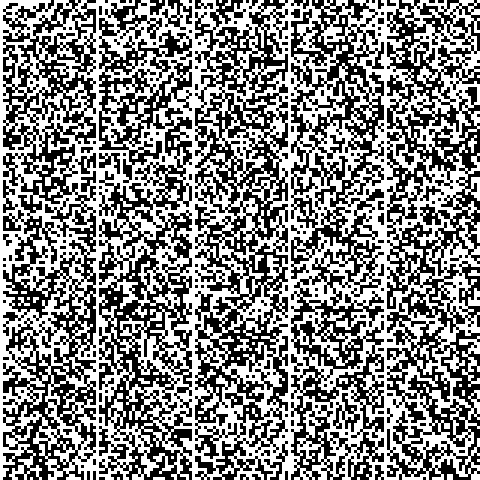

In [ ]:
visualRepresentation(generatedData, height, width)

In [ ]:
generatedData[0]

'0'

# Plotting generated data

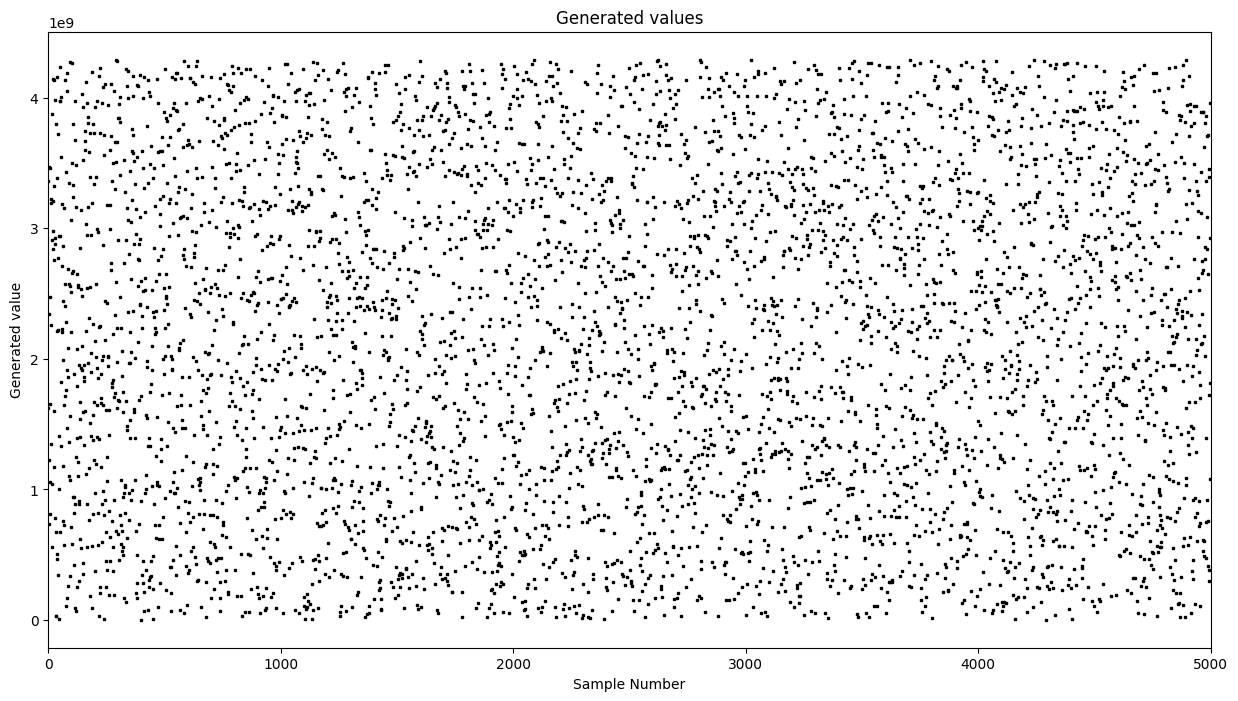

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Set figure and axes objects for plot
fig, ax = plt.subplots()

fig.set_size_inches(15, 8)

for x in range(5000):
  # Plots the calculated probabilities as blue points on the graph
  ax.plot(x, int(PRNGHandler.basic_equation_based2(), 2), marker='s', color='black', markersize=2)


# Plots a label for each axis
plt.ylabel('Generated value')
plt.xlabel('Sample Number')
# Plots the title
plt.title('Generated values')

# Ensures x-axis starts at 0
ax.set_xlim([0, 5000])


# Displays plot
plt.show()


# Text visualisation

In [ ]:
for i in range(20):
  print(''.join('*' if bit=='1' else '.' for bit in currentGenerator()))

..***.*......*...**.*.***.....*
...**..**...****.*....*.*....**
*...****..**..****...****..*..*
.***.*.*..*.**.*.*.*.**.*.**.**
*.**.**...*****......*....*...*
..*..**.**.***......**...**..**
*.......*****.*...*..*.*..**..*
*.*.*.....*......**.*****..*.**
.**..*******.***.*..***.**....*
*....**.*.*..******.**...*...**
*.........****.***...*..**.*..*
.*...*.**...*.**.*..***..***.**
...*****...*.******.*.**.**...*
.*..*...*.*.*..***....*...*..**
*..***....*...**.*...**..***..*
...**.*.**.**.****.*..**.*.*.**
..*...*****.*..*.****.*.......*
***..*.**.*****..**.***......**
...*****.*.....*.*..*.*....*..*
*.*..*****.*.*.***.****...**.**
